<a href="https://colab.research.google.com/github/felipevarelacarvalho/SeedDetection/blob/main/SeedDetection_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

  LIZBETHS CODE

In [ ]:
image_directory = "/content/drive/MyDrive/Colab Notebooks/DataSet/task_miniset_felipe-2021_08_31_19_40_53-cvat for images 1.1/images/Images_Bulk_labelling_mini/MiniSET5"
annotations_directory = "/content/drive/MyDrive/Colab Notebooks/DataSet/task_miniset_felipe-2021_08_31_19_40_53-cvat for images 1.1/annotations.xml"

In [ ]:
import os

import argparse
import shutil
import numpy as np
from lxml import etree
from tqdm import tqdm
import pandas as pd
import pathlib as path

In [ ]:
root = etree.parse(annotations_directory).getroot()
anno = []
image_info = {}

for image in root.iter('image'):
  #print(image.attrib)
  image_name = image.attrib['name']
  image_width = image.attrib['width']
  image_height = image.attrib['height']
  #print(image_name)
  #image_info = {'name':image_name}

  for box in image.findall('box'):
    if box.attrib['label'] == 'Seed':
      #print(box.items())
      
      for key, value in box.items():
        image_info['name'] = image_name
        image_info['width'] = image_width
        image_info['height'] = image_height
        image_info[key] = value
        #print(image_info.keybs())
      #print(image_info)
      
      #print(anno)
      anno.append(image_info)
      image_info = {} 
  

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

In [ ]:
sample_image = Image.open(image_directory + '/' + anno[0]['name'])
box_coor = [float(anno[1]['xtl']), float(anno[1]['ytl']), float(anno[1]['xbr']), float(anno[1]['ybr'])]
img_bbox = ImageDraw.Draw(sample_image)
img_bbox.rectangle(box_coor, outline="green") 

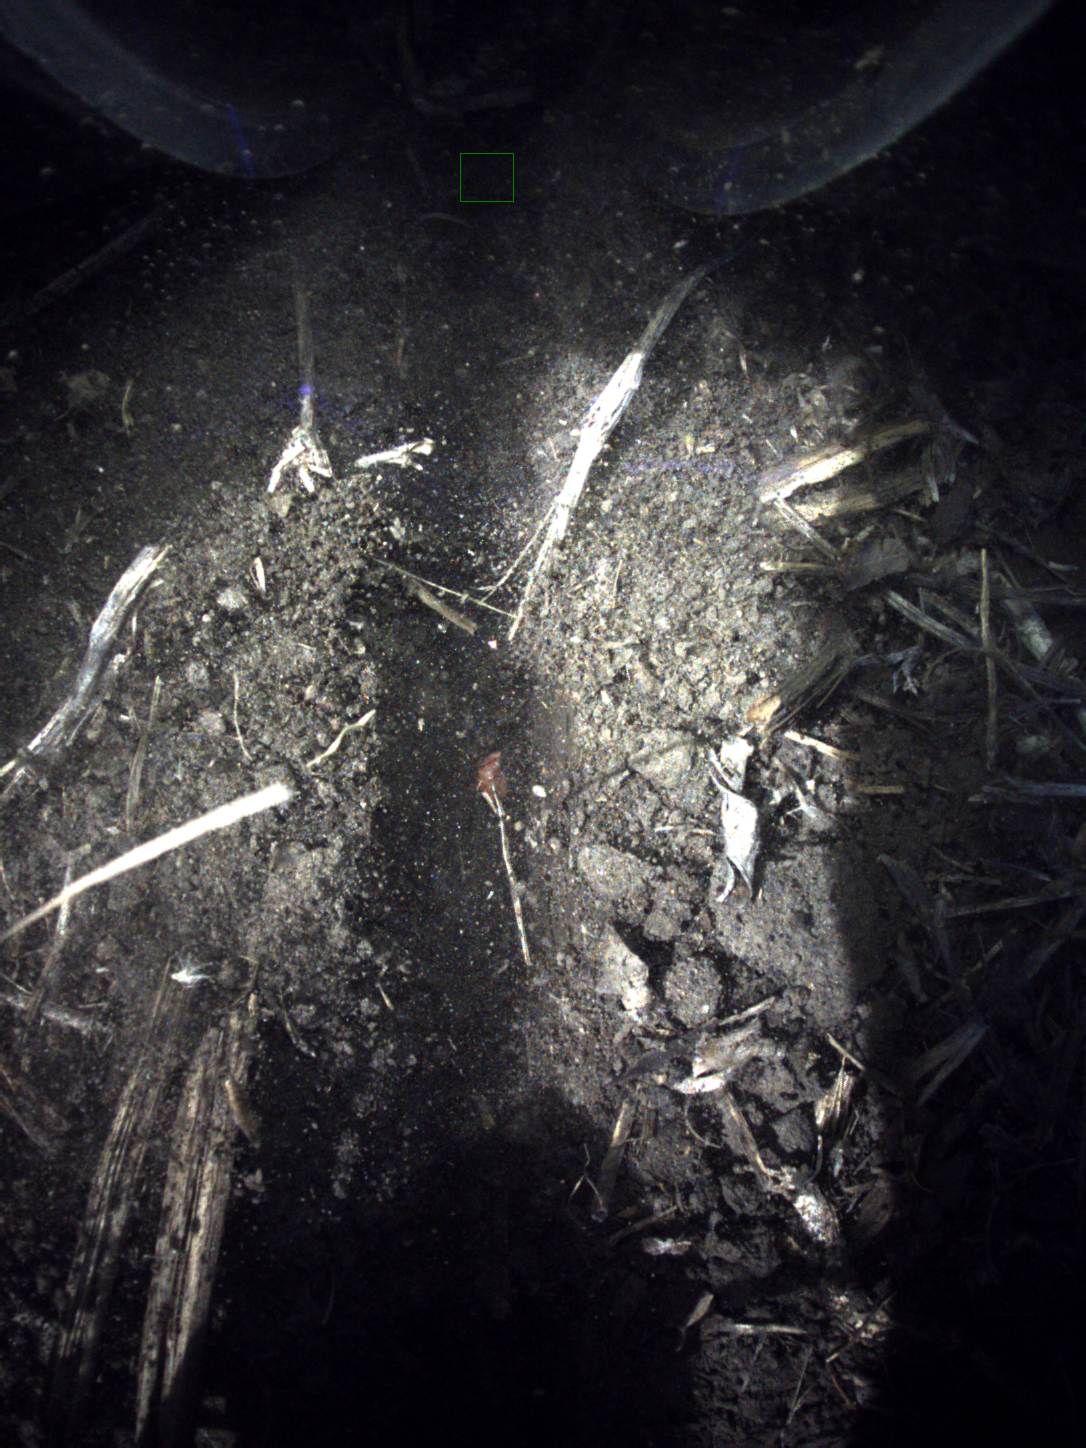

In [ ]:
sample_image

In [ ]:
width = []
height = []
image_name = []
labels =[]
xtl = []
ytl = []
xbr = []
ybr = []

for item in anno:
  #print(item.keys())
  image_name.append(item['name'])
  width.append(item['width'])
  height.append(item['height'])
  labels.append(0)
  xtl.append(float(item['xtl']))
  ytl.append(float(item['ytl']))
  xbr.append(float(item['xbr']))
  ybr.append(float(item['ybr']))

df = pd.DataFrame(list(zip(image_name, width, height, labels, xtl, ytl,xbr,ybr)),
               columns =['Name','width', 'height', 'Label', 'xmin', 'ymin','xmax','ymax'])



In [ ]:
df

Name width  ...    xmax     ymax
0    image_sensorid_4_frame_312300_ts_1620159456.28...  1086  ...  522.79   810.54
1    image_sensorid_4_frame_312292_ts_1620159455.75...  1086  ...  513.96   201.17
2    image_sensorid_4_frame_312292_ts_1620159455.75...  1086  ...  479.06   812.22
3    image_sensorid_4_frame_312278_ts_1620159454.82...  1086  ...  508.49  1043.16
4    image_sensorid_4_frame_312276_ts_1620159454.68...  1086  ...  539.89   395.14
..                                                 ...   ...  ...     ...      ...
272  image_sensorid_4_frame_248452_ts_1620155199.63...  1086  ...  497.56   491.00
273  image_sensorid_4_frame_248442_ts_1620155198.96...  1086  ...  497.56  1358.79
274  image_sensorid_4_frame_248433_ts_1620155198.36...  1086  ...  516.06   738.22
275  image_sensorid_4_frame_248432_ts_1620155198.30...  1086  ...  517.74   734.86
276  image_sensorid_4_frame_248425_ts_1620155197.83...  1086  ...  531.78   738.96

[277 rows x 8 columns]

In [ ]:
df_train = df

In [ ]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images_path = Path('/content/drive/MyDrive/Colab Notebooks/SignsDataSet/images')
anno_path = Path('/content/drive/MyDrive/Colab Notebooks/SignsDataSet/annotations')

In [ ]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [ ]:
df_train = generate_train_df(anno_path)

KeyboardInterrupt: ignored

In [ ]:
#label encode target
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

KeyError: ignored

In [ ]:
print(df_train.shape)
df_train.head()

(277, 8)


Name width  ...     xbr      ybr
0  image_sensorid_4_frame_312300_ts_1620159456.28...  1086  ...  522.79   810.54
1  image_sensorid_4_frame_312292_ts_1620159455.75...  1086  ...  513.96   201.17
2  image_sensorid_4_frame_312292_ts_1620159455.75...  1086  ...  479.06   812.22
3  image_sensorid_4_frame_312278_ts_1620159454.82...  1086  ...  508.49  1043.16
4  image_sensorid_4_frame_312276_ts_1620159454.68...  1086  ...  539.89   395.14

[5 rows x 8 columns]

## Resizing images and Bounding boxes

In [ ]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [ ]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, int(0.75*sz)))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, int(0.75*sz)))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [ ]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(Path(image_directory + '/' + row['Name']), train_path_resized, create_bb_array(row.values), 300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [ ]:
print(df_train.shape)
df_train

(277, 10)


Name  ...                        new_bb
0    image_sensorid_4_frame_312300_ts_1620159456.28...  ...  [115.0, 129.0, 125.0, 143.0]
1    image_sensorid_4_frame_312292_ts_1620159455.75...  ...    [24.0, 127.0, 30.0, 141.0]
2    image_sensorid_4_frame_312292_ts_1620159455.75...  ...  [115.0, 118.0, 125.0, 131.0]
3    image_sensorid_4_frame_312278_ts_1620159454.82...  ...  [151.0, 126.0, 161.0, 139.0]
4    image_sensorid_4_frame_312276_ts_1620159454.68...  ...    [53.0, 136.0, 60.0, 148.0]
..                                                 ...  ...                           ...
272  image_sensorid_4_frame_248452_ts_1620155199.63...  ...          [0.0, 0.0, 0.0, 0.0]
273  image_sensorid_4_frame_248442_ts_1620155198.96...  ...          [0.0, 0.0, 0.0, 0.0]
274  image_sensorid_4_frame_248433_ts_1620155198.36...  ...          [0.0, 0.0, 0.0, 0.0]
275  image_sensorid_4_frame_248432_ts_1620155198.30...  ...          [0.0, 0.0, 0.0, 0.0]
276  image_sensorid_4_frame_248425_ts_1620155197.83...  ...          [0.0, 0.0, 0.0, 0.0]

[277 rows x 10 columns]

## Sample Image

In [ ]:
# im = cv2.imread(str(df_train.values[58][8]))
im = cv2.imread( image_directory + '/' + str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(bb)
print(im.shape)

[369.92 465.61 418.69 509.33]
(1448, 1086, 3)


In [ ]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([369., 465., 417., 508.], dtype=float32)

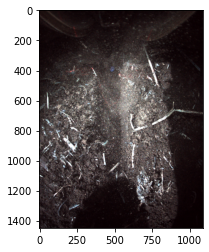

In [ ]:
plt.imshow(im)

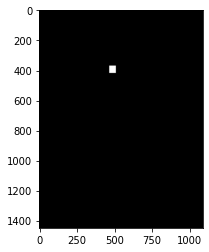

In [ ]:
plt.imshow(Y, cmap='gray')

Data Augumentation

In [ ]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [ ]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

Sample Image

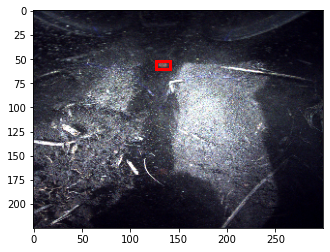

In [ ]:
#original
im = cv2.imread(str(df_train.values[68][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[68][9])

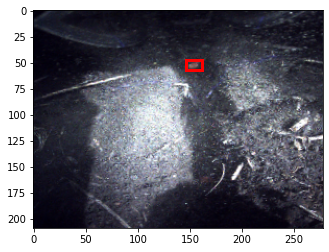

In [ ]:
# after transformation
im, bb = transformsXY(str(df_train.values[68][8]),df_train.values[68][9],True )
show_corner_bb(im, bb)

Train Valid Split

In [ ]:
df_train = df_train.reset_index()

In [ ]:
df_train

index  ...                        new_bb
0        0  ...  [115.0, 129.0, 125.0, 143.0]
1        1  ...    [24.0, 127.0, 30.0, 141.0]
2        2  ...  [115.0, 118.0, 125.0, 131.0]
3        3  ...  [151.0, 126.0, 161.0, 139.0]
4        4  ...    [53.0, 136.0, 60.0, 148.0]
..     ...  ...                           ...
272    272  ...          [0.0, 0.0, 0.0, 0.0]
273    273  ...          [0.0, 0.0, 0.0, 0.0]
274    274  ...          [0.0, 0.0, 0.0, 0.0]
275    275  ...          [0.0, 0.0, 0.0, 0.0]
276    276  ...          [0.0, 0.0, 0.0, 0.0]

[277 rows x 11 columns]

In [ ]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['Label']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Dataset

In [ ]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [ ]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [ ]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
print(valid_ds.bb)

[array([ 75., 124.,  83., 138.], dtype=float32)
 array([168., 120., 175., 139.], dtype=float32)
 array([145., 121., 152., 142.], dtype=float32)
 array([ 51., 123.,  58., 137.], dtype=float32)
 array([150., 118., 158., 134.], dtype=float32)
 array([ 53., 135.,  58., 154.], dtype=float32)
 array([ 41., 121.,  47., 132.], dtype=float32)
 array([ 81., 127.,  89., 138.], dtype=float32)
 array([149., 125., 159., 137.], dtype=float32)
 array([ 93., 121., 104., 145.], dtype=float32)
 array([ 22., 126.,  28., 141.], dtype=float32)
 array([ 64., 132.,  73., 143.], dtype=float32)
 array([ 68., 119.,  74., 140.], dtype=float32)
 array([ 28., 119.,  35., 133.], dtype=float32)
 array([0., 0., 0., 0.], dtype=float32)
 array([ 76., 121.,  83., 137.], dtype=float32)
 array([ 91., 125.,  98., 139.], dtype=float32)
 array([169., 119., 176., 144.], dtype=float32)
 array([ 72., 129.,  81., 146.], dtype=float32)
 array([104., 108., 111., 142.], dtype=float32)
 array([122., 128., 134., 141.], dtype=float32)


Model

In [ ]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

Training

In [ ]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [ ]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [ ]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [ ]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [ ]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])
train_loss 2.949 val_loss 478249984.000 val_acc 0.000
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,

0.22062391609088328

In [ ]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.198 val_loss 0.171 val_acc 1.000
train_loss 0.197 val_loss 0.168 val_acc 1.000
train_loss 0.191 val_loss 0.164 val_acc 1.000
train_loss 0.190 val_loss 0.160 val_acc 1.000
train_loss 0.186 val_loss 0.156 val_acc 1.000
train_loss 0.182 val_loss 0.152 val_acc 1.000
train_loss 0.173 val_loss 0.148 val_acc 1.000
train_loss 0.170 val_loss 0.144 val_acc 1.000
train_loss 0.168 val_loss 0.140 val_acc 1.000
train_loss 0.166 val_loss 0.136 val_acc 1.000


0.16588415387529054

Making Predictions

In [ ]:
# choose random image from validation set
a = np.asarray(X_val['new_path'])
print(a)

['/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized/image_sensorid_4_frame_312123_ts_1620159444.4870_GPS_42.0449897914_-93.7053967000.png'
 '/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized/image_sensorid_4_frame_285717_ts_1620157684.0370_GPS_42.0436875704_-93.7052495000.png'
 '/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized/image_sensorid_4_frame_265732_ts_1620156351.6670_GPS_42.0427883738_-93.7052866422.png'
 '/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized/image_sensorid_4_frame_285558_ts_1620157673.4370_GPS_42.0434718093_-93.7052497000.png'
 '/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized/image_sensorid_4_frame_249484_ts_1620155268.4340_GPS_42.0450442407_-93.7053232740.png'
 '/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized/image_sensorid_4_frame_249608_ts_1620155276.7010_GPS_42.0452123797_-93.7053233595.png'
 '/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized/image_sensorid_4_frame_310346_

In [ ]:
# resizing test image
im = read_image('/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized/image_sensorid_4_frame_312261_ts_1620159453.6870_GPS_42.0451769973_-93.7053970000.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/DataSet/images_test/image_sensorid_4_frame_312261_ts_1620159453.6870_GPS_42.0451769973_-93.7053970000.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

False

In [ ]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'/content/drive/MyDrive/Colab Notebooks/DataSet/images_resized/image_sensorid_4_frame_312261_ts_1620159453.6870_GPS_42.0451769973_-93.7053970000.png'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [ ]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 209, 278])

In [ ]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 5.7266, -2.1515, -2.4512, -1.9609]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[ 72.7813,  97.9865,  79.5560, 100.6614]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [ ]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(values=tensor([5.7266], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([0], device='cuda:0'))

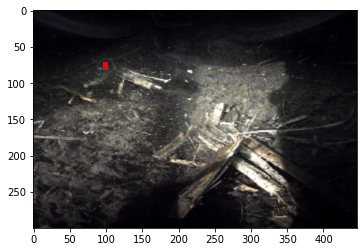

In [ ]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])